In [1]:
import numpy as np
np.set_printoptions(suppress=True)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import torch
import pyro
import pyro.distributions as dist

torch.manual_seed(0)
pyro.set_rng_seed(0)

import time


In [2]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target

In [3]:
from sklearn.linear_model import LinearRegression

my_linear_regression = LinearRegression().fit(X,y)

print(my_linear_regression.intercept_)
print(my_linear_regression.coef_)

-36.941920207184324
[ 0.43669329  0.00943578 -0.10732204  0.64506569 -0.00000398 -0.00378654
 -0.42131438 -0.43451375]


In [4]:
def model(X, y):
    
    
    mean = pyro.sample(f"beta_0", dist.Normal(0.0, 1.0))
    
    for i in range(0, X.shape[1]):
        beta_i = pyro.sample(f"beta_{i+1}", dist.Normal(0.0, 1.0))
        mean = mean + (beta_i * X[:, i])
    
    sigma = pyro.sample("sigma", dist.HalfCauchy(scale=10.0))
    
    
    with pyro.plate("data", y.shape[0]):
        observation = pyro.sample(f"obs", dist.Normal(mean, sigma), obs=y)

In [5]:
from pyro.infer import MCMC, NUTS


pyro.clear_param_store()
my_kernel = NUTS(model, max_tree_depth=7)


my_mcmc = MCMC(my_kernel,
               num_samples=6000,
               warmup_steps=100)

X_torch = torch.tensor(X)
y_torch = torch.tensor(y)

start_time = time.time()
my_mcmc.run(X_torch,y_torch)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

Sample: 100%|██████████| 6100/6100 [52:15,  1.95it/s, step size=2.68e-08, acc. prob=0.823]

Inference ran for 3135.45 seconds


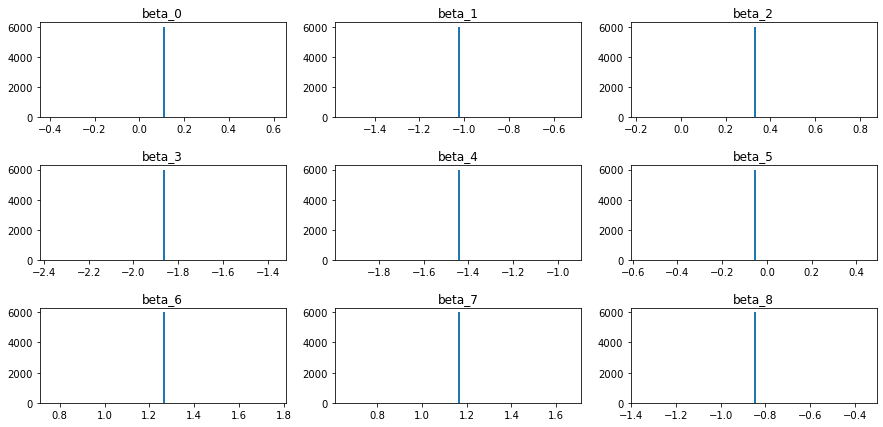

In [31]:
figure, axis = plt.subplots(3,3, figsize=(15,7))


for key, ax in zip(my_mcmc.get_samples(), axis.ravel()):
    ax.set_title(key)
    ax.hist(my_mcmc.get_samples()[key], bins=100)

plt.subplots_adjust(hspace=0.5)

## Scaled Data

In [32]:
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
X_scaled = my_scaler.fit_transform(X)

In [34]:
my_scaled_linear_regression = LinearRegression().fit(X_scaled,y)

print(my_scaled_linear_regression.intercept_)
print(my_scaled_linear_regression.coef_)

2.0685581690891386
[ 0.8296193   0.11875165 -0.26552688  0.30569623 -0.004503   -0.03932627
 -0.89988565 -0.870541  ]


In [35]:
pyro.clear_param_store()
my_kernel = NUTS(model, max_tree_depth=7)


my_mcmc = MCMC(my_kernel,
               num_samples=6000,
               warmup_steps=100)

X_torch = torch.tensor(X_scaled)
y_torch = torch.tensor(y)

start_time = time.time()
my_mcmc.run(X_torch,y_torch)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

Sample: 100%|██████████| 6100/6100 [41:32,  2.45it/s, step size=4.58e-03, acc. prob=0.979]

Inference ran for 2492.29 seconds


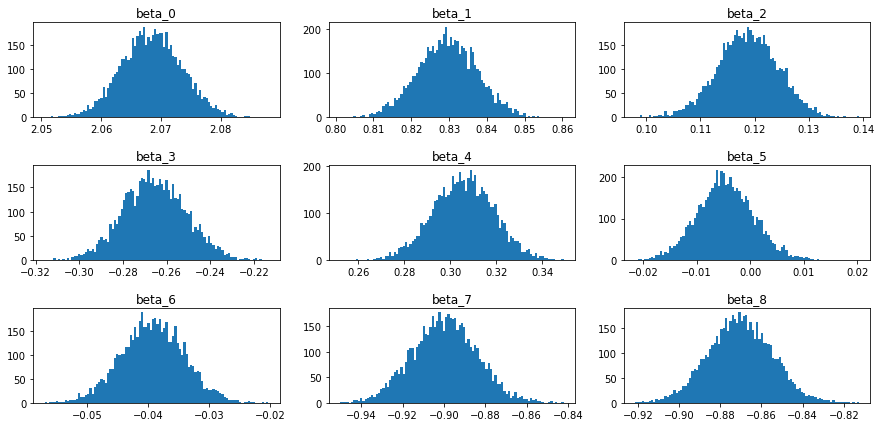

In [36]:
figure, axis = plt.subplots(3,3, figsize=(15,7))


for key, ax in zip(my_mcmc.get_samples(), axis.ravel()):
    ax.set_title(key)
    ax.hist(my_mcmc.get_samples()[key], bins=100)

plt.subplots_adjust(hspace=0.5)

In [48]:
beta_df = pd.DataFrame(my_mcmc.get_samples())


i = 0
for col in beta_df:
    if (col != 'beta_0'):
        if ('beta_' in col):
            print(col)
            
            beta_df['beta_0'] -= (beta_df[col] * my_scaler.mean_[i])/my_scaler.scale_[i]
            beta_df[col] /= my_scaler.scale_[i]
            
            i += 1

beta_1
beta_2
beta_3
beta_4
beta_5
beta_6
beta_7
beta_8


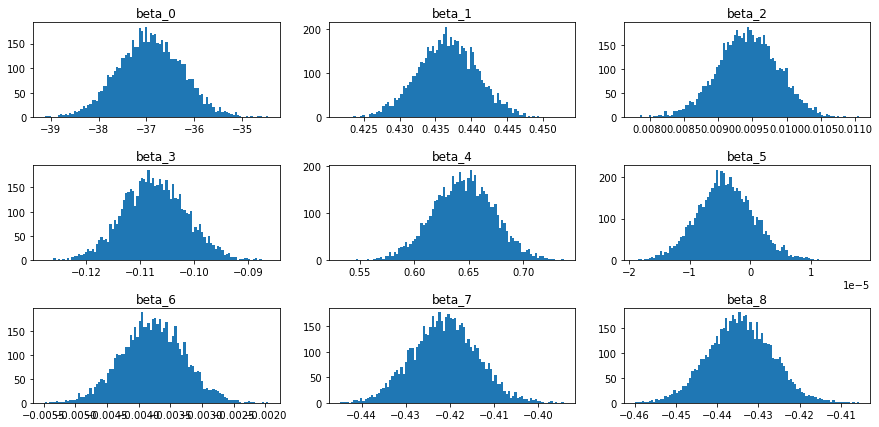

In [49]:
figure, axis = plt.subplots(3,3, figsize=(15,7))


for col, ax in zip(beta_df.columns, axis.ravel()):
    ax.set_title(col)
    ax.hist(beta_df[col], bins=100)

plt.subplots_adjust(hspace=0.5)

In [70]:
higher_than_low_bound = beta_df['beta_0'] > np.percentile(beta_df['beta_0'], 5.0)
lower_than_high_bound = beta_df['beta_0'] < np.percentile(beta_df['beta_0'], 95.0)

print(beta_df.loc[higher_than_low_bound & lower_than_high_bound, 'beta_0'].min())
print(beta_df.loc[higher_than_low_bound & lower_than_high_bound, 'beta_0'].max())

-38.01766
-35.82859


In [77]:
proba = 0.95

lower_limit = (1.0 - proba)*100/2
upper_limit = 100.0 - lower_limit

for col in beta_df:
    print(col)
    print(np.percentile(beta_df[col], lower_limit))
    print(np.mean(beta_df[col]))
    print(np.percentile(beta_df[col], upper_limit))

beta_0
-38.24675416946411
-36.92719
-35.6102801322937
beta_1
0.4282860845327377
0.4366368
0.4447938710451126
beta_2
0.008529715845361352
0.009429412
0.010284772259183228
beta_3
-0.11864778138697146
-0.10729554
-0.09567378479987383
beta_4
0.5888726353645325
0.6449066
0.6993044674396515
beta_5
-1.310775919591833e-05
-4.0591885e-06
5.48106388578162e-06
beta_6
-0.00476371783297509
-0.0037814484
-0.002797397162066773
beta_7
-0.4353449381887913
-0.42119223
-0.40675695016980173
beta_8
-0.44939151182770726
-0.434358
-0.41923381835222245
sigma
0.717320142686367
0.7243138
0.731475155055523
